# Neonatal Incubator Display Reader Pipeline

This notebook walks through the end-to-end workflow for detecting neonatal incubator display regions, extracting numeric readings, validating performance, and preparing artifacts for deployment.


## Roadmap

1. Environment setup
2. Dataset exploration & preprocessing
3. Annotation workflow (Label Studio)
4. YOLO training data preparation
5. Train & evaluate YOLO detector
6. Detection inference sanity check
7. OCR post-processing with EasyOCR
8. Metric validation (detection + OCR)
9. Persist structured readings & model export
10. Streamlit dashboard integration hooks


In [1]:
# 1. Environment setup
%pip install -q ultralytics==8.1.0 easyocr==1.7.1 opencv-python==4.10.0.84 "torch>=2.0.0" torchvision torchaudio pandas numpy matplotlib seaborn scikit-learn albumentations==1.4.3 streamlit plotly python-bidi ipympl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 2. Common imports & paths
from pathlib import Path
import json
import random
import shutil
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

def resolve_project_root() -> Path:
    cwd = Path.cwd()
    if (cwd / "dataset").exists():
        return cwd
    if (cwd.parent / "dataset").exists():
        return cwd.parent
    return cwd

PROJECT_DIR = resolve_project_root()
DATASET_DIR = PROJECT_DIR / "dataset"
WORK_DIR = PROJECT_DIR / 'artifacts'
LABELS_DIR = WORK_DIR / 'labels'
IMAGES_DIR = WORK_DIR / 'images'
YOLO_DATA_DIR = WORK_DIR / 'yolo'
MODEL_DIR = PROJECT_DIR / 'models'
WORK_DIR.mkdir(exist_ok=True)
LABELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)
YOLO_DATA_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

CLASS_NAMES = [
    'spo2_label', 'spo2_value',
    'heart_rate_label', 'heart_rate_value',
    'pi_value',
    'air_temp_label', 'air_temp_value',
    'skin_temp_label', 'skin_temp_value',
    'humidity_label', 'humidity_value',
    'oxygen_label', 'oxygen_value',
    'warning_banner', 'waveform_region'
]
CLASS_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
ID_TO_CLASS_NAME = {idx: name for name, idx in CLASS_MAP.items()}
CLASS_MAP

{'spo2_label': 0,
 'spo2_value': 1,
 'heart_rate_label': 2,
 'heart_rate_value': 3,
 'pi_value': 4,
 'air_temp_label': 5,
 'air_temp_value': 6,
 'skin_temp_label': 7,
 'skin_temp_value': 8,
 'humidity_label': 9,
 'humidity_value': 10,
 'oxygen_label': 11,
 'oxygen_value': 12,
 'warning_banner': 13,
 'waveform_region': 14}

## Dataset exploration

We inspect image resolutions, sample frames, and luminance/contrast differences. Both dark and light themes exist; grayscale conversions will help standardize OCR preprocessing.


In [3]:
image_paths = []
if DATASET_DIR.exists():
    for pattern in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
        image_paths.extend(DATASET_DIR.glob(pattern))
image_paths = sorted({path.resolve() for path in image_paths})
len(image_paths)

261

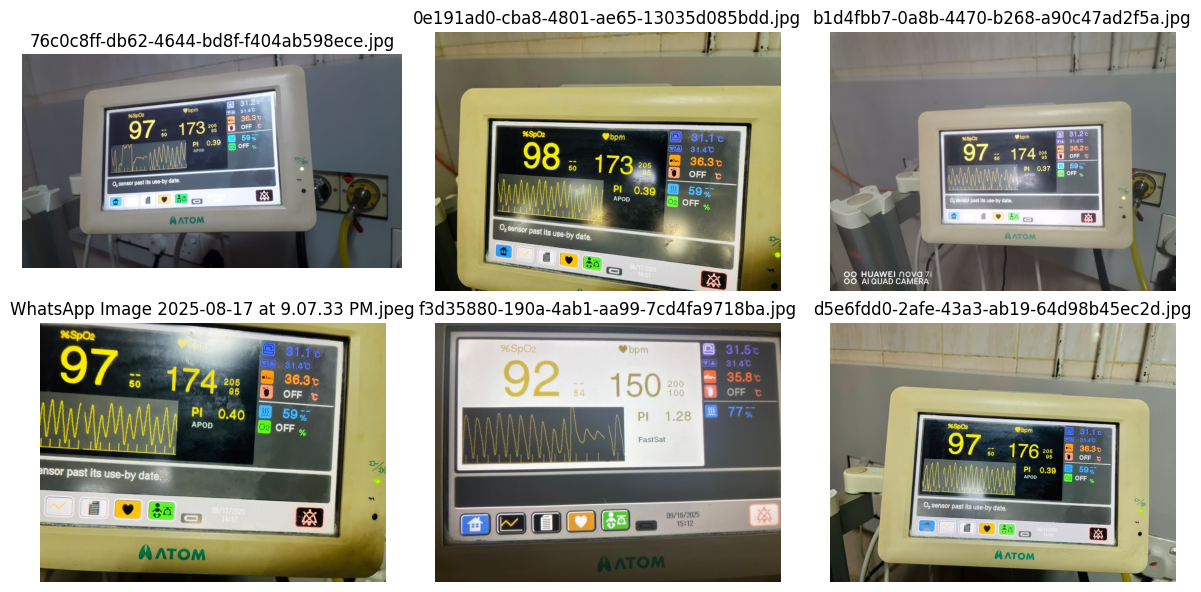

In [4]:
def plot_samples(paths, n=6, cols=3):
    sample_paths = random.sample(paths, min(n, len(paths)))
    rows = int(np.ceil(len(sample_paths) / cols))
    plt.figure(figsize=(4 * cols, 3 * rows))
    for idx, path in enumerate(sample_paths, 1):
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        plt.title(path.name)
        plt.axis('off')
    plt.tight_layout()

plot_samples(image_paths)

In [5]:
def compute_brightness(path):
    gray = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2GRAY)
    return gray.mean()

brightness = pd.Series({p.name: compute_brightness(p) for p in image_paths})
brightness.describe()

count    261.000000
mean     114.943115
std       16.213817
min       43.631552
25%      114.498931
50%      118.018000
75%      121.505554
max      148.440418
dtype: float64

## Annotation workflow (Label Studio)

Use [Label Studio](https://labelstud.io/) to annotate bounding boxes for each target region.

1. Install Label Studio (one-off setup):
   ```bash
   pip install label-studio
   label-studio start --port 8080
   ```
2. Create a new project "Incubator Display Detection".
3. Import the `dataset/` directory images.
4. Configure the labeling interface with bounding boxes for each class listed in `CLASS_NAMES`.
5. Annotate all images (or start with 100 images, then iteratively improve).
6. Export annotations as _YOLO_ or _Label Studio JSON_.

If JSON export is used, run the next cell to convert to YOLO format.


## Quick manual labeling helper
If you prefer to label a handful of samples directly inside the notebook, use the widget below. It lets you draw rectangles for the key numeric readings (SpO₂, heart rate, temperature, humidity) and saves YOLO-format text files into `artifacts/manual_labels`. For larger annotation jobs, Label Studio remains the recommended tool.

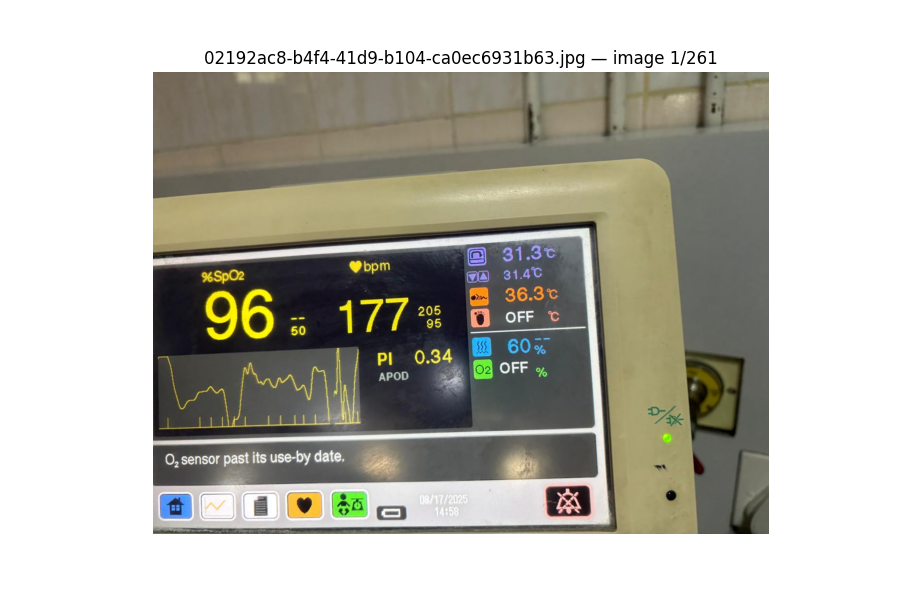

KeyError: 'SpO₂ (%)'

KeyError: 'SpO₂ (%)'

KeyError: 'SpO₂ (%)'

In [6]:
try:
    import ipympl  # noqa: F401  # ensure interactive matplotlib is available
    get_ipython().run_line_magic("matplotlib", "widget")
except Exception as exc:
    print("Interactive backend unavailable — install ipympl and restart the kernel for drag-to-draw support.")
    print(f"Falling back to static inline backend: {exc}")
    get_ipython().run_line_magic("matplotlib", "inline")

import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.widgets import RectangleSelector
from matplotlib import patches

FOCUS_CLASSES = [
    ("spo2_value", "SpO₂ (%)"),
    ("heart_rate_value", "Heart rate (bpm)"),
    ("skin_temp_value", "Baby temperature (°C)"),
    ("humidity_value", "Humidity (%)"),
]

MANUAL_LABEL_DIR = WORK_DIR / "manual_labels"
MANUAL_LABEL_DIR.mkdir(parents=True, exist_ok=True)


class ManualLabeler:
    """Lightweight GUI for drawing bounding boxes and saving YOLO labels."""

    def __init__(self, image_paths, class_map, output_dir):
        self.image_paths = list(image_paths)
        self.class_map = class_map
        self.output_dir = Path(output_dir)
        self.index = 0
        self.fig = None
        self.ax = None
        self.selector = None
        self.image = None
        self.current_boxes = []  # [{'cls': str, 'bbox': (x1, y1, x2, y2), 'patch': Patch}]

        self.dropdown = widgets.Dropdown(
            options=FOCUS_CLASSES,
            description="Class:",
            layout=widgets.Layout(width="280px"),
        )
        self.info_area = widgets.Output()
        self.btn_next = widgets.Button(description="Save & Next", button_style="success")
        self.btn_skip = widgets.Button(description="Skip", button_style="warning")
        self.btn_prev = widgets.Button(description="Previous")
        self.btn_undo = widgets.Button(description="Undo last")
        self.btn_clear = widgets.Button(description="Clear all", button_style="danger")

        self.btn_next.on_click(self.save_and_next)
        self.btn_skip.on_click(self.skip)
        self.btn_prev.on_click(self.prev_image)
        self.btn_undo.on_click(self.undo_last)
        self.btn_clear.on_click(self.clear_boxes)

    def start(self):
        if not self.image_paths:
            with self.info_area:
                clear_output()
                print("No images available in dataset directory.")
            return
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self._load_existing_annotation()
        self._render()
        controls = widgets.HBox([
            self.dropdown,
            self.btn_prev,
            self.btn_next,
            self.btn_skip,
            self.btn_undo,
            self.btn_clear,
        ])
        display(widgets.VBox([controls, self.info_area]))

    # ------------------------------------------------------------------
    def _render(self):
        if self.fig is not None:
            plt.close(self.fig)
        current_path = Path(self.image_paths[self.index])
        bgr = cv2.imread(str(current_path))
        if bgr is None:
            raise FileNotFoundError(current_path)
        self.image = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        self.fig, self.ax = plt.subplots(figsize=(9, 6))
        self.ax.imshow(self.image)
        self.ax.set_title(f"{current_path.name} — image {self.index + 1}/{len(self.image_paths)}")
        self.ax.axis("off")
        self.selector = RectangleSelector(
            self.ax,
            self._on_select,
            useblit=True,
            button=[1],
            minspanx=5,
            minspany=5,
            spancoords="pixels",
            interactive=True,
            drag_from_anywhere=True,
        )
        self._draw_existing_boxes()
        plt.show()
        self._log(f"Ready: draw box, release mouse, class={self.dropdown.label}.")

    def _on_select(self, click, release):
        if click.xdata is None or release.xdata is None:
            return
        x1, x2 = sorted([click.xdata, release.xdata])
        y1, y2 = sorted([click.ydata, release.ydata])
        cls_name = self.dropdown.value
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            edgecolor="lime",
            linewidth=2,
            facecolor="none",
        )
        self.ax.add_patch(rect)
        self.fig.canvas.draw_idle()
        self.current_boxes.append({"cls": cls_name, "bbox": (x1, y1, x2, y2), "patch": rect})
        self._log(f"Added {cls_name} box: {(int(x1), int(y1), int(x2), int(y2))}")

    def _yolo_line(self, bbox, cls_name):
        h, w = self.image.shape[:2]
        x1, y1, x2, y2 = bbox
        cx = ((x1 + x2) / 2) / w
        cy = ((y1 + y2) / 2) / h
        bw = (x2 - x1) / w
        bh = (y2 - y1) / h
        return f"{self.class_map[cls_name]} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}"

    def save_current(self):
        if not self.current_boxes:
            self._log("Nothing to save for this image.")
            return False
        label_path = self.output_dir / f"{Path(self.image_paths[self.index]).stem}.txt"
        lines = [self._yolo_line(box["bbox"], box["cls"]) for box in self.current_boxes]
        with open(label_path, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))
        self._log(f"Saved {len(lines)} boxes -> {label_path}")
        return True

    def save_and_next(self, *_):
        saved = self.save_current()
        if self.index < len(self.image_paths) - 1:
            self.index += 1
            self._load_existing_annotation()
            self._render()
        elif saved:
            self._log("Reached last image. All done!")

    def skip(self, *_):
        self._log("Skipped without saving.")
        if self.index < len(self.image_paths) - 1:
            self.index += 1
            self._load_existing_annotation()
            self._render()

    def prev_image(self, *_):
        if self.index == 0:
            self._log("Already at first image.")
            return
        self.index -= 1
        self._load_existing_annotation()
        self._render()

    def undo_last(self, *_):
        if not self.current_boxes:
            self._log("No boxes to undo.")
            return
        box = self.current_boxes.pop()
        box["patch"].remove()
        self.fig.canvas.draw_idle()
        self._log("Removed last box.")

    def clear_boxes(self, *_):
        for box in self.current_boxes:
            box["patch"].remove()
        self.current_boxes.clear()
        self.fig.canvas.draw_idle()
        self._log("Cleared all boxes for this image.")

    def _load_existing_annotation(self):
        self.current_boxes = []
        label_path = self.output_dir / f"{Path(self.image_paths[self.index]).stem}.txt"
        if not label_path.exists():
            return
        bgr = cv2.imread(str(self.image_paths[self.index]))
        if bgr is None:
            return
        self.image = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        h, w = self.image.shape[:2]
        with open(label_path, "r", encoding="utf-8") as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
        for line in lines:
            parts = line.split()
            if len(parts) != 5:
                continue
            cls_id, cx, cy, bw, bh = parts
            cls_id = int(cls_id)
            cls_name = ID_TO_CLASS_NAME.get(cls_id)
            if cls_name not in dict(FOCUS_CLASSES):
                continue
            cx, cy, bw, bh = map(float, (cx, cy, bw, bh))
            x1 = (cx - bw / 2) * w
            x2 = (cx + bw / 2) * w
            y1 = (cy - bh / 2) * h
            y2 = (cy + bh / 2) * h
            self.current_boxes.append({
                "cls": cls_name,
                "bbox": (x1, y1, x2, y2),
                "patch": None,
            })

    def _draw_existing_boxes(self):
        if not self.current_boxes:
            return
        updated = []
        for box in self.current_boxes:
            x1, y1, x2, y2 = box["bbox"]
            rect = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                edgecolor="yellow",
                linewidth=2,
                facecolor="none",
                linestyle="--",
            )
            self.ax.add_patch(rect)
            box["patch"] = rect
            updated.append(box)
        self.current_boxes = updated
        self.fig.canvas.draw_idle()
        self._log(f"Loaded {len(updated)} existing boxes.")

    def _log(self, message):
        with self.info_area:
            clear_output(wait=True)
            print(message)


if image_paths:
    manual_labeler = ManualLabeler(image_paths, CLASS_MAP, MANUAL_LABEL_DIR)
    manual_labeler.start()
else:
    print("Dataset folder is empty. Add images to use the manual labeler.")

In [9]:
# Convert Label Studio JSON to YOLO format
import math
from collections import defaultdict

def ls_to_yolo(json_path, output_dir, class_map):
    output_dir = Path(output_dir)
    (output_dir / 'labels').mkdir(parents=True, exist_ok=True)
    (output_dir / 'images').mkdir(parents=True, exist_ok=True)

    with open(json_path, 'r', encoding='utf-8') as f:
        records = json.load(f)

    copy_count = 0
    for item in records:
        original_path = Path(item['data']['image'].replace('file://', ''))
        image = cv2.imread(str(original_path))
        if image is None:
            print(f"Skip missing image: {original_path}")
            continue
        h, w = image.shape[:2]
        target_image_path = output_dir / 'images' / original_path.name
        shutil.copy2(original_path, target_image_path)

        yolo_lines = []
        for ann in item['annotations'][0]['result']:
            cls_name = ann['value']['rectanglelabels'][0]
            if cls_name not in class_map:
                continue
            x = ann['value']['x'] / 100 * w
            y = ann['value']['y'] / 100 * h
            width = ann['value']['width'] / 100 * w
            height = ann['value']['height'] / 100 * h
            cx = (x + width / 2) / w
            cy = (y + height / 2) / h
            yolo_lines.append(f"{class_map[cls_name]} {cx:.6f} {cy:.6f} {width / w:.6f} {height / h:.6f}")

        label_path = output_dir / 'labels' / original_path.with_suffix('.txt').name
        with open(label_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(yolo_lines))
        copy_count += 1

    print(f"Converted {copy_count} annotations to YOLO format -> {output_dir}")

# Example usage:
# ls_to_yolo('label_studio_export.json', YOLO_DATA_DIR, CLASS_MAP)

## Train/val split

After conversion, split into train/val/test sets in YOLO format.


> **Note:** The next steps assume you have *finished* annotating bounding boxes and have exported YOLO-style labels. If you still need to label the images, follow the Label Studio workflow in the previous section first. Once `YOLO_DATA_DIR` contains matching `images/` and `labels/` folders, you can run the split, YAML, training, and evaluation helpers below. Uncomment the example calls (the lines starting with `#`) when you are ready to execute them.

In [10]:
def split_dataset(yolo_dir, train=0.7, val=0.2, test=0.1, seed=42):
    assert math.isclose(train + val + test, 1.0, rel_tol=1e-6)
    rng = random.Random(seed)
    images = sorted((Path(yolo_dir) / 'images').glob('*.jpg'))
    rng.shuffle(images)
    n = len(images)
    train_cut = int(n * train)
    val_cut = train_cut + int(n * val)
    splits = {
        'train': images[:train_cut],
        'val': images[train_cut:val_cut],
        'test': images[val_cut:]
    }

    split_root = Path(yolo_dir) / 'splits'
    for split_name, paths in splits.items():
        img_out = split_root / split_name / 'images'
        lbl_out = split_root / split_name / 'labels'
        img_out.mkdir(parents=True, exist_ok=True)
        lbl_out.mkdir(parents=True, exist_ok=True)
        for path in paths:
            shutil.copy2(path, img_out / path.name)
            lbl_path = Path(yolo_dir) / 'labels' / path.with_suffix('.txt').name
            shutil.copy2(lbl_path, lbl_out / lbl_path.name)

    print({k: len(v) for k, v in splits.items()})
    return split_root

# split_root = split_dataset(YOLO_DATA_DIR)

## YOLO data config

The Ultralytics trainer needs a YAML descriptor.


In [11]:
def write_data_yaml(split_root, class_names):
    data_yaml = {
        'train': str((split_root / 'train' / 'images').resolve()),
        'val': str((split_root / 'val' / 'images').resolve()),
        'test': str((split_root / 'test' / 'images').resolve()),
        'nc': len(class_names),
        'names': class_names
    }
    path = split_root / 'incubator.yml'
    with open(path, 'w', encoding='utf-8') as f:
        yaml.safe_dump(data_yaml, f, sort_keys=False)
    return path

import yaml
# data_yaml_path = write_data_yaml(split_root, CLASS_NAMES)
# data_yaml_path

## Train YOLOv8 detector

Train with Ultralytics. Adjust epochs, image size, and augmentations as performance dictates.


In [12]:
def train_detector(data_yaml, epochs=100, imgsz=640, batch=16, model='yolov8n.pt', project='incubator', name='yolov8n-incubator'):
    model = YOLO(model)
    results = model.train(
        data=str(data_yaml),
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=20,
        project=project,
        name=name,
        exist_ok=True
    )
    return model, results

# detector, train_results = train_detector(data_yaml_path)

## Evaluate detector

Use Ultralytics metrics (mAP, precision, recall) and export confusion matrices.


In [13]:
def evaluate_detector(model, data_yaml):
    metrics = model.val(data=str(data_yaml))
    print(metrics)
    return metrics

# metrics = evaluate_detector(detector, data_yaml_path)

In [14]:
def visualize_predictions(model, image_paths, class_names, conf=0.25, max_images=5):
    subset = random.sample(image_paths, min(len(image_paths), max_images))
    for path in subset:
        res = model.predict(source=str(path), conf=conf, verbose=False)
        res[0].plot()
        display(res[0].plot())

# visualize_predictions(detector, image_paths, CLASS_NAMES)

## OCR post-processing

With bounding boxes detected, run EasyOCR to extract digits and normalize values.


In [15]:
import easyocr
import re

reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
NUMERIC_CLASSES = [c for c in CLASS_NAMES if c.endswith('value')]

def preprocess_roi(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    return cv2.resize(blur, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)

def clean_numeric(text):
    cleaned = re.sub(r'[^0-9.%]', '', text)
    cleaned = cleaned.replace('..', '.')
    return cleaned.strip('.')

def extract_value(roi):
    processed = preprocess_roi(roi)
    results = reader.readtext(processed)
    if not results:
        return None, 0.0
    value, score = max(results, key=lambda x: x[2])
    text = clean_numeric(value[1])
    return text or None, score

def run_ocr_on_detection(image_path, model, conf=0.25):
    image = cv2.imread(str(image_path))
    results = model.predict(source=str(image_path), conf=conf, verbose=False)
    det = results[0]
    outputs = {}
    for box, cls, score in zip(det.boxes.xyxy.cpu().numpy(), det.boxes.cls.cpu().numpy(), det.boxes.conf.cpu().numpy()):
        cls = int(cls)
        name = CLASS_NAMES[cls]
        x1, y1, x2, y2 = map(int, box)
        roi = image[y1:y2, x1:x2]
        if name in NUMERIC_CLASSES:
            text, ocr_score = extract_value(roi)
            outputs[name] = {
                'bbox': box.tolist(),
                'det_conf': float(score),
                'value': text,
                'ocr_conf': float(ocr_score)
            }
        else:
            outputs[name] = {
                'bbox': box.tolist(),
                'det_conf': float(score)
            }
    return outputs

# sample_outputs = run_ocr_on_detection(image_paths[0], detector)
# sample_outputs

Using CPU. Note: This module is much faster with a GPU.


Progress: |███████████████-----------------------------------| 31.7% Complete

KeyboardInterrupt: 

## Accuracy validation

1. Detection metrics already from YOLO (mAP).
2. OCR string accuracy: compare numeric strings vs. ground truth collected manually.
3. Numeric accuracy: convert to float and compute MAE / RMSE per channel.


In [ ]:
def evaluate_ocr(predictions, ground_truth):
    # predictions: list of dicts with 'value' keys per class
    # ground_truth: list of dicts with same structure but numeric str
    rows = []
    for pred, gt in zip(predictions, ground_truth):
        row = {}
        for cls in NUMERIC_CLASSES:
            pred_val = pred.get(cls, {}).get('value')
            true_val = gt.get(cls)
            if pred_val is None or true_val is None:
                continue
            row[f'{cls}_match'] = int(pred_val == true_val)
            try:
                row[f'{cls}_ae'] = abs(float(pred_val) - float(true_val))
            except ValueError:
                row[f'{cls}_ae'] = np.nan
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

# Example usage with manually curated ground truth JSON
# with open('ground_truth.json', 'r') as f:
#     gt_records = json.load(f)
# preds = [run_ocr_on_detection(Path(rec['image_path']), detector) for rec in gt_records]
# metrics_df = evaluate_ocr(preds, [rec['values'] for rec in gt_records])
# metrics_df.mean()

## Persist structured readings

Aggregate per-image readings for downstream analytics or dashboard ingestion.


In [ ]:
def export_predictions(predictions, destination='artifacts/inference.csv'):
    rows = []
    for image_path, outputs in predictions.items():
        row = {'image': image_path}
        for cls, payload in outputs.items():
            value = payload.get('value')
            if value is not None:
                row[cls] = value
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(destination, index=False)
    print(f'Saved {len(df)} records -> {destination}')
    return df

# preds_dict = {str(p): run_ocr_on_detection(p, detector) for p in image_paths[:10]}
# export_predictions(preds_dict)

## Model export

After training, copy the best weights to `models/incubator_yolov8n.pt` for deployment.


In [ ]:
def export_best_weights(run_dir, target_path=MODEL_DIR / 'incubator_yolov8n.pt'):
    run_dir = Path(run_dir)
    best = run_dir / 'weights' / 'best.pt'
    shutil.copy2(best, target_path)
    print(f'Exported weights -> {target_path}')

# export_best_weights('runs/detect/yolov8n-incubator')

## Streamlit integration hooks

The notebook hands-off to the `streamlit_app/app.py` module, which loads the exported YOLO model and OCR pipeline for live inference.
